## Задание 1

### Аналитический метод

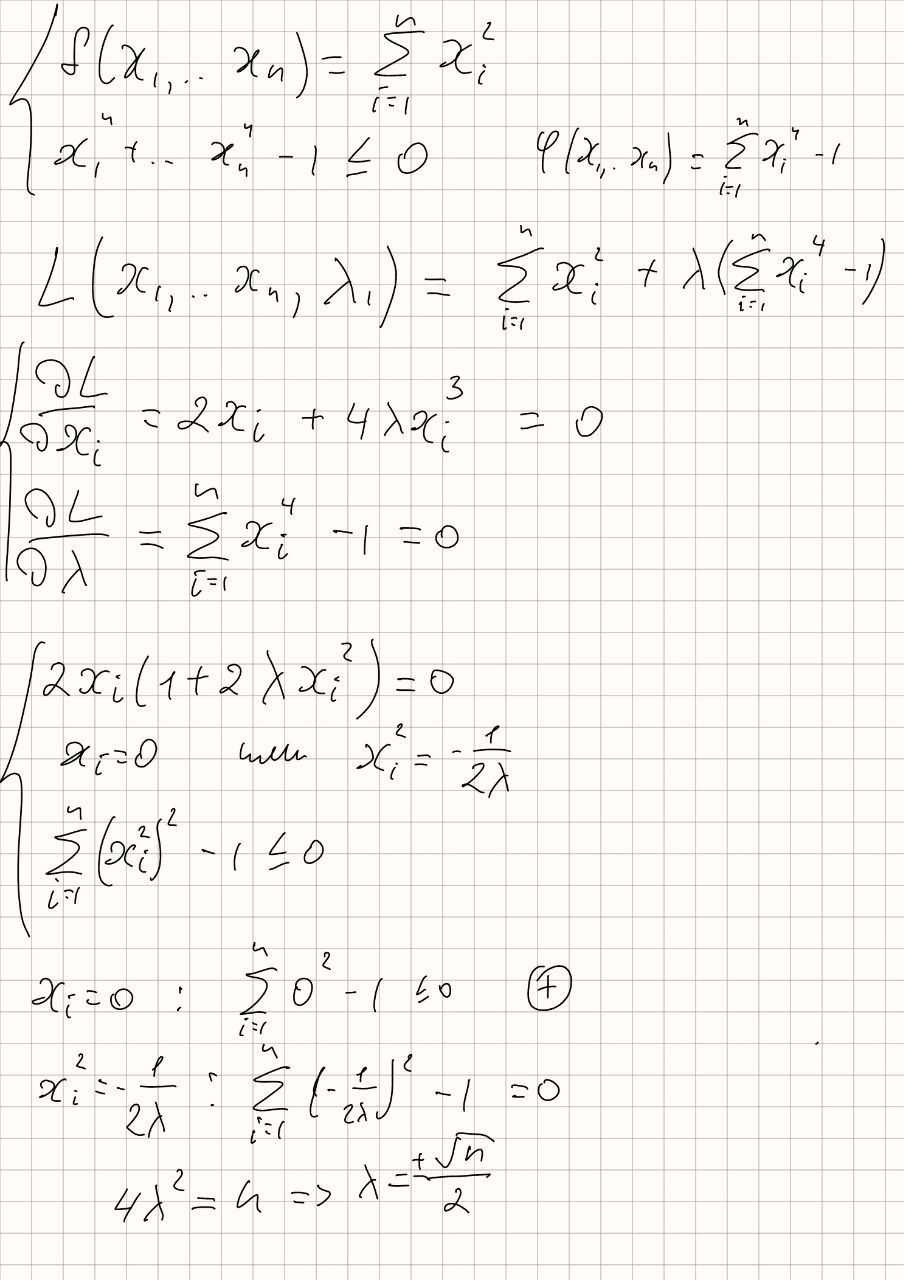

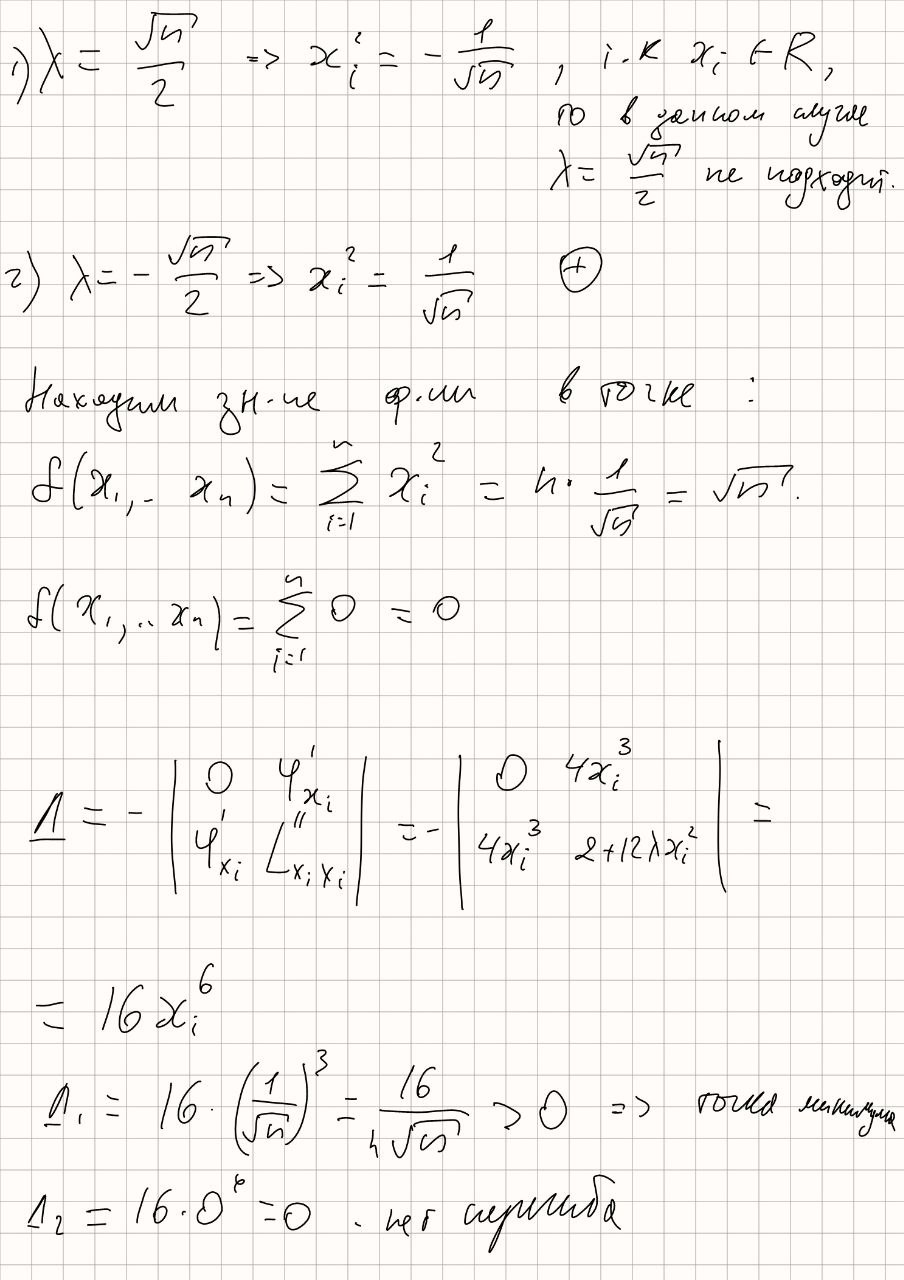

### Проверка при помощи оптимизатора

In [78]:
from scipy.optimize import minimize
import numpy as np

# Определение целевой функции
def objective_function(x):
    return (x**2).sum()

# Определение ограничений на множестве
def constraint(x):
    return (x**4).sum() - 1

# Задание начального приближения
initial_guess = np.array([0**(1/4)]*10)

# Определение типа задачи оптимизации (например, 'SLSQP' для последовательной квадратичной программы)
method = 'SLSQP'

# Поиск минимума с учетом ограничений
result = minimize(objective_function, initial_guess, method=method, constraints={'type': 'eq', 'fun': constraint})

# Вывод результатов
print("Минимум функции:", result.fun)
print("Аргументы, при которых достигается минимум:", result.x)


Минимум функции: 0.0
Аргументы, при которых достигается минимум: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Рассмотрим теперь для $ n = \sqrt{10}$   точки $ x_{i} = \frac{1}{\sqrt[4]{n}}$

In [79]:
initial_guess = np.array([10**(1/4)]*10)

result = minimize(objective_function, initial_guess, method=method, constraints={'type': 'eq', 'fun': constraint})

# Вывод результатов
print("Минимум функции:", result.fun)
print("Аргументы, при которых достигается минимум:", result.x)

Минимум функции: 3.1622776601542704
Аргументы, при которых достигается минимум: [0.56234425 0.56234425 0.56234425 0.56234425 0.56234042 0.56234042
 0.56234039 0.56234039 0.5623427  0.56233191]


Видим, что значение минимума функции достигается как раз для наших $x_i$, что говорит о правильности аналитического решения

## Задание 2

### Аналитическое решение метода ветвей и границ

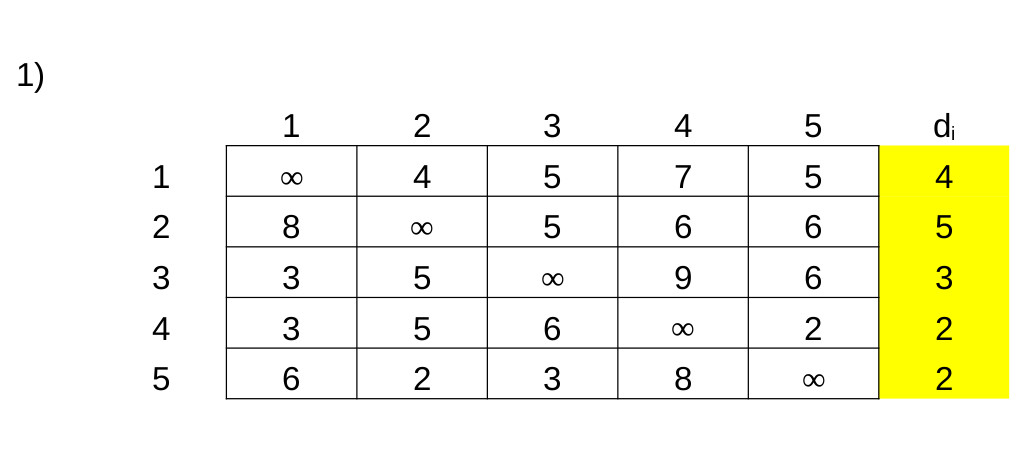

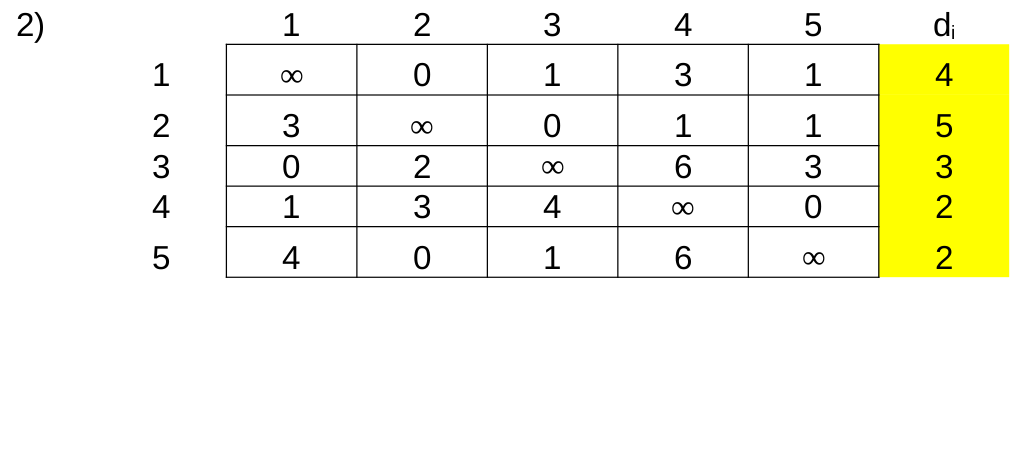

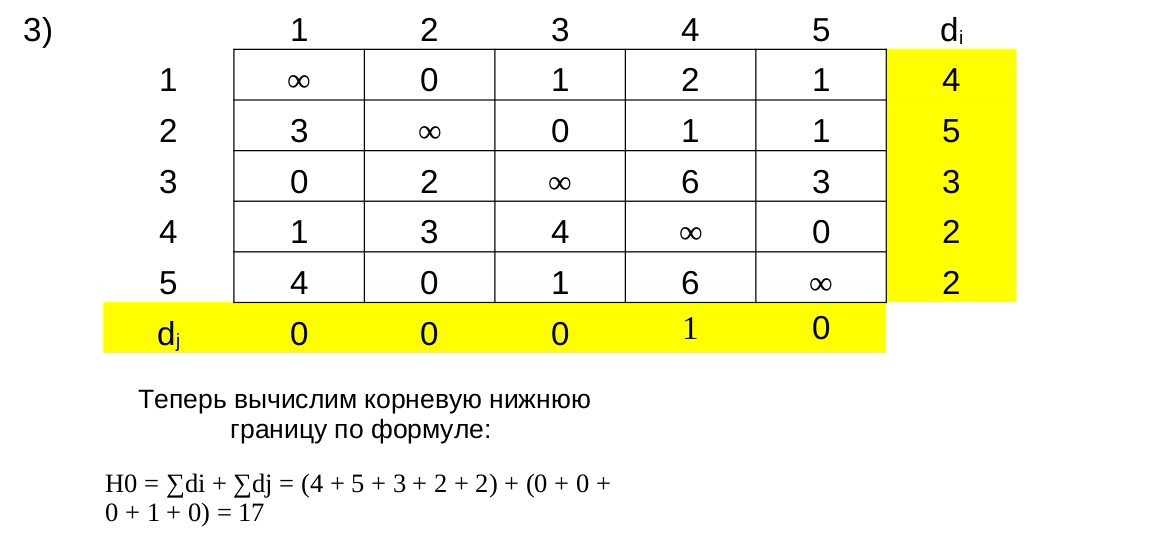

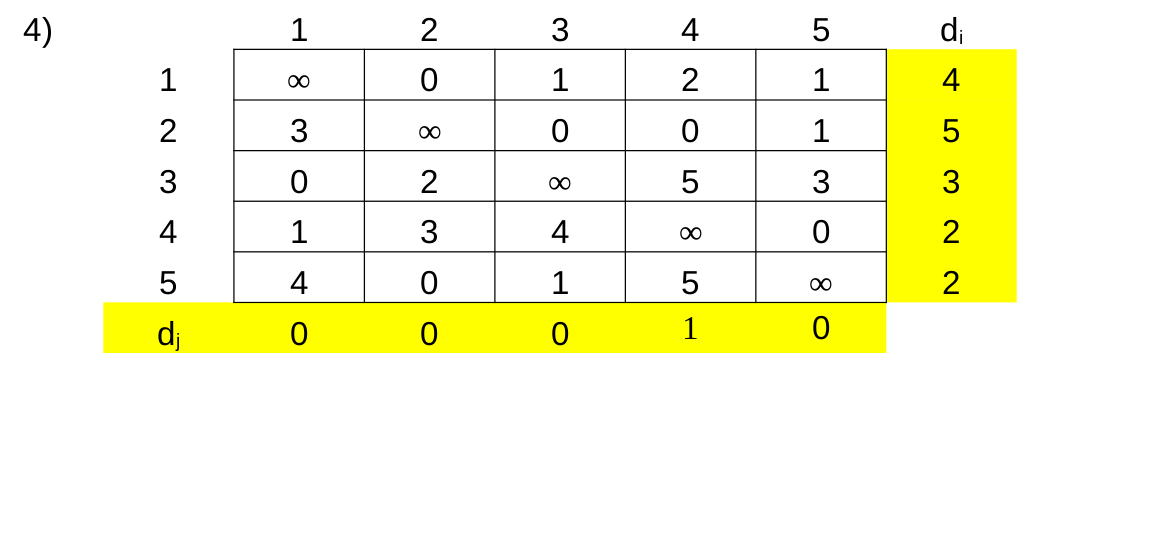

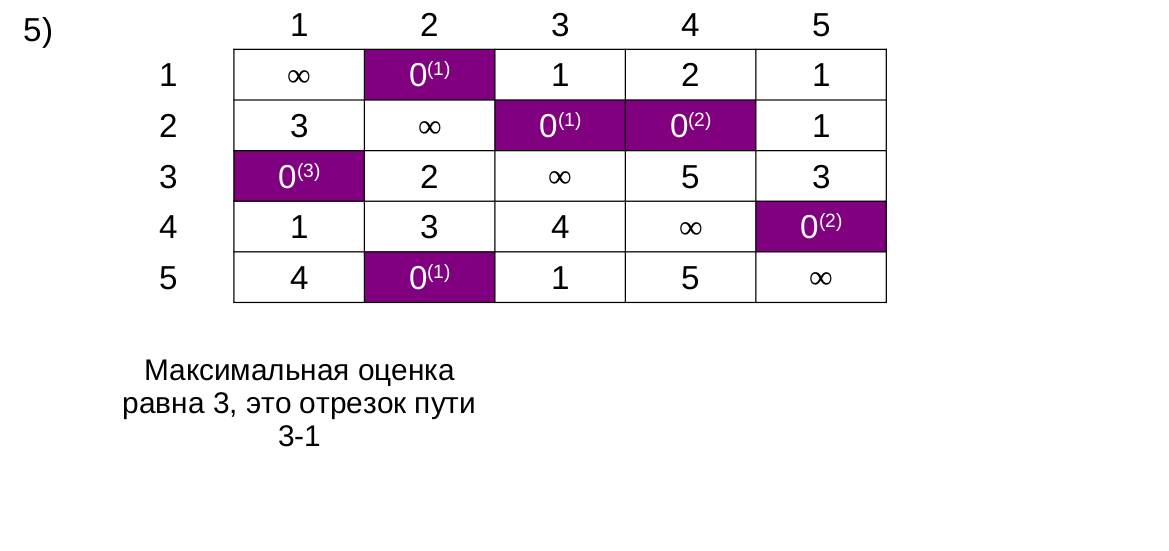

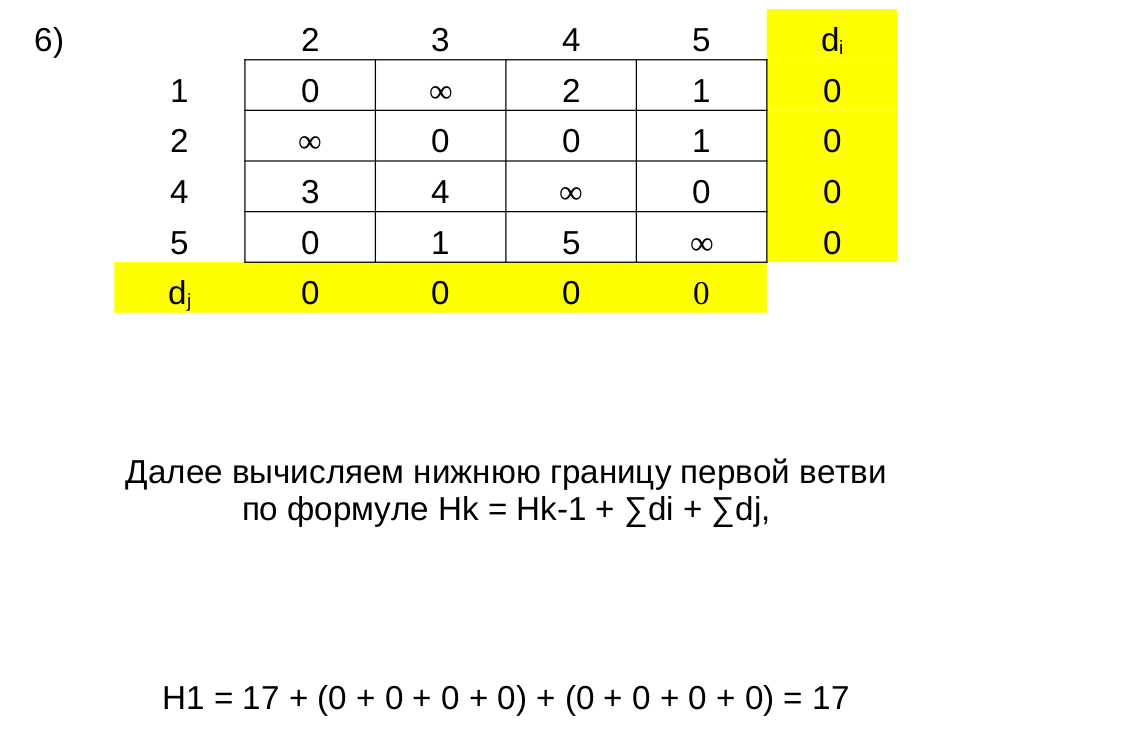

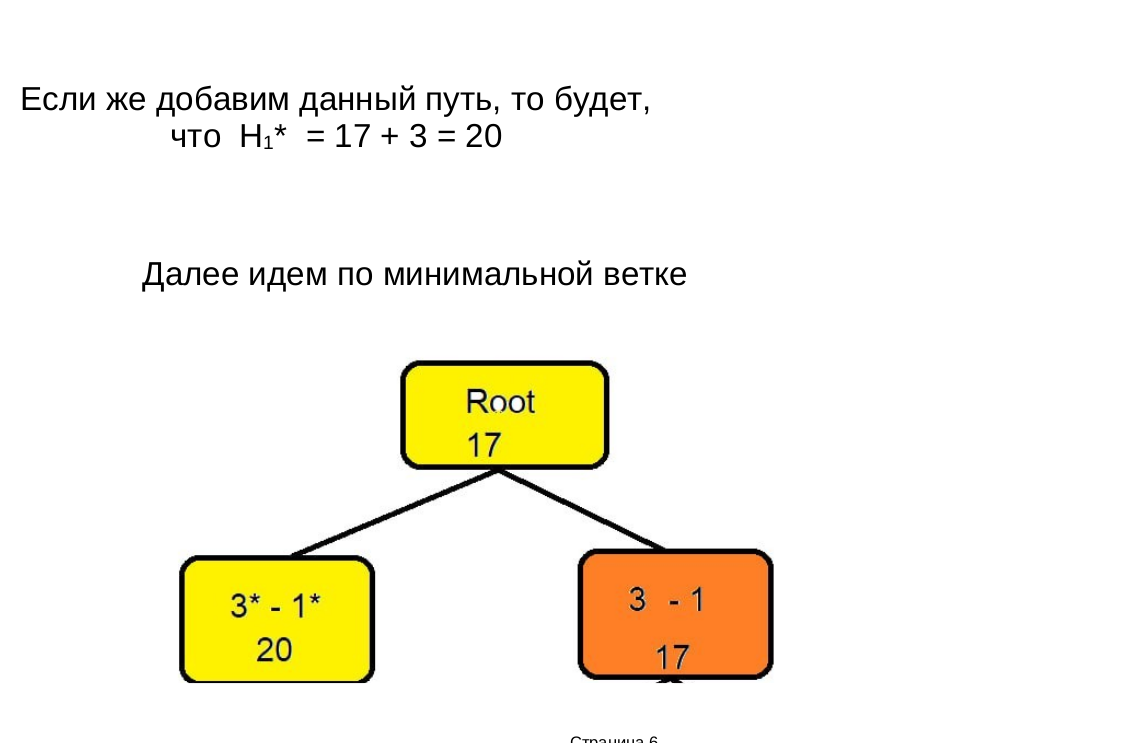

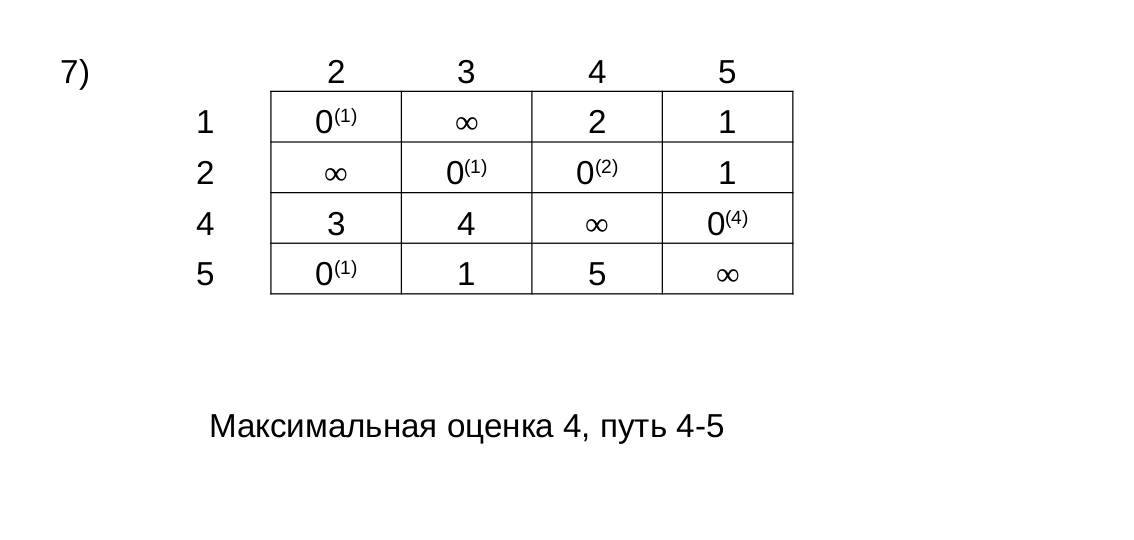

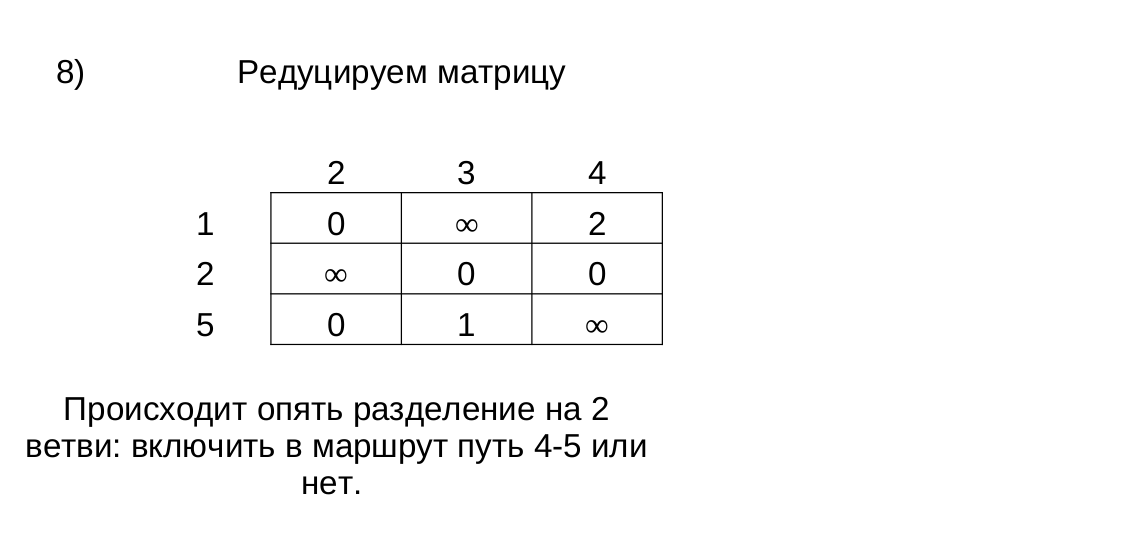

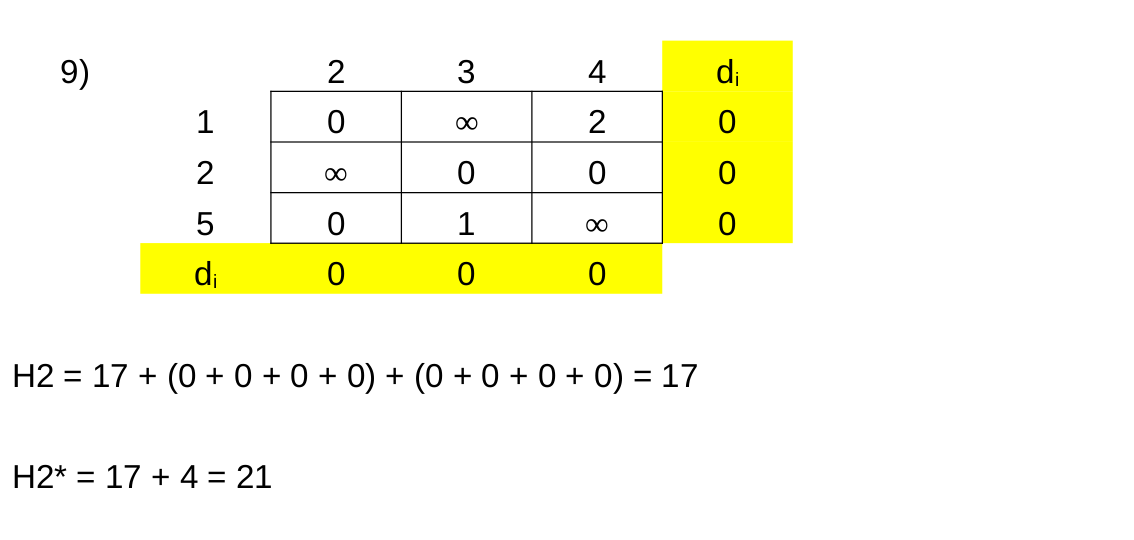

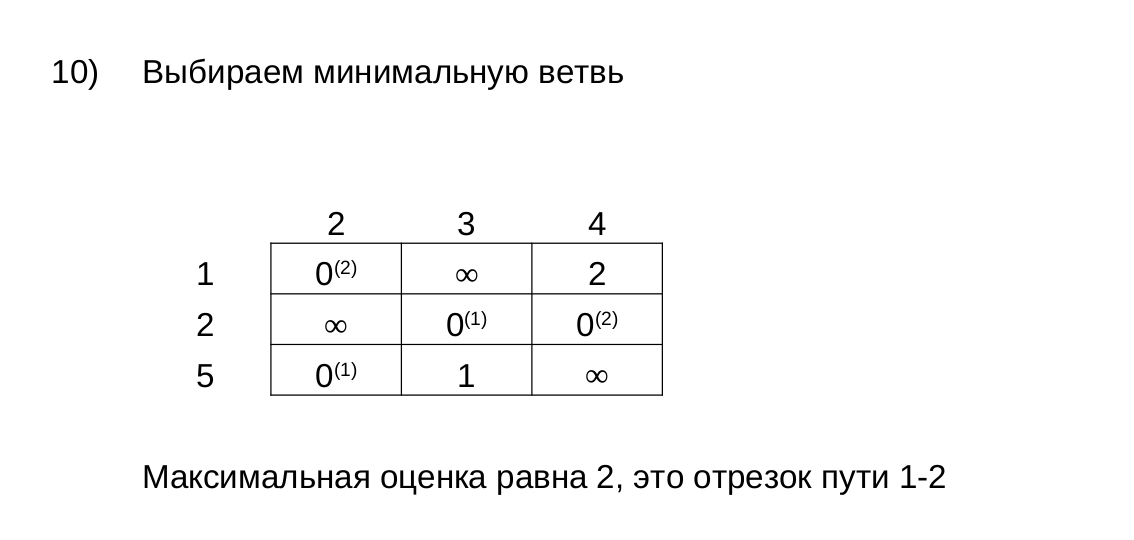

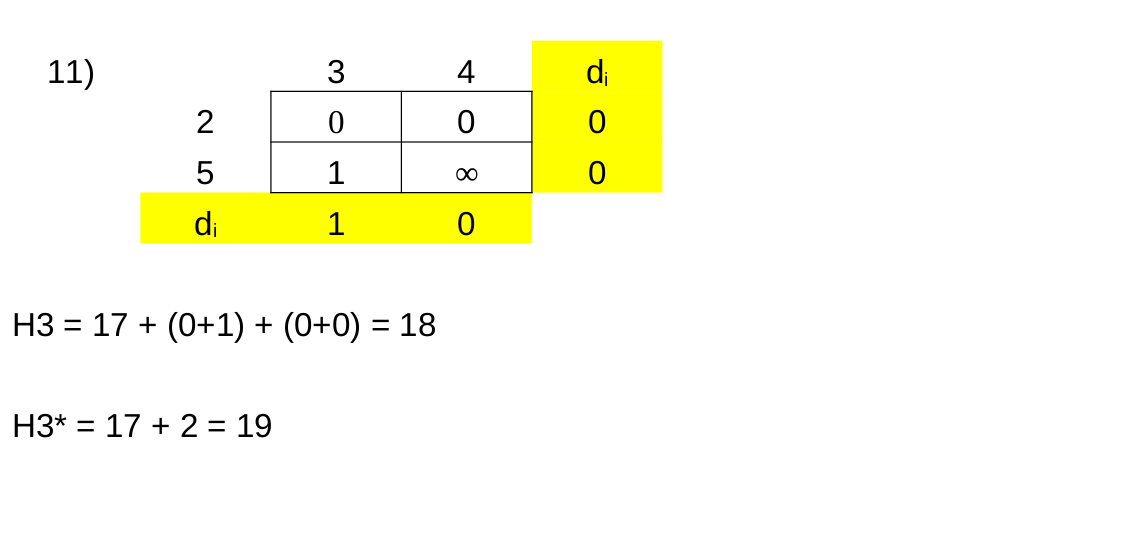

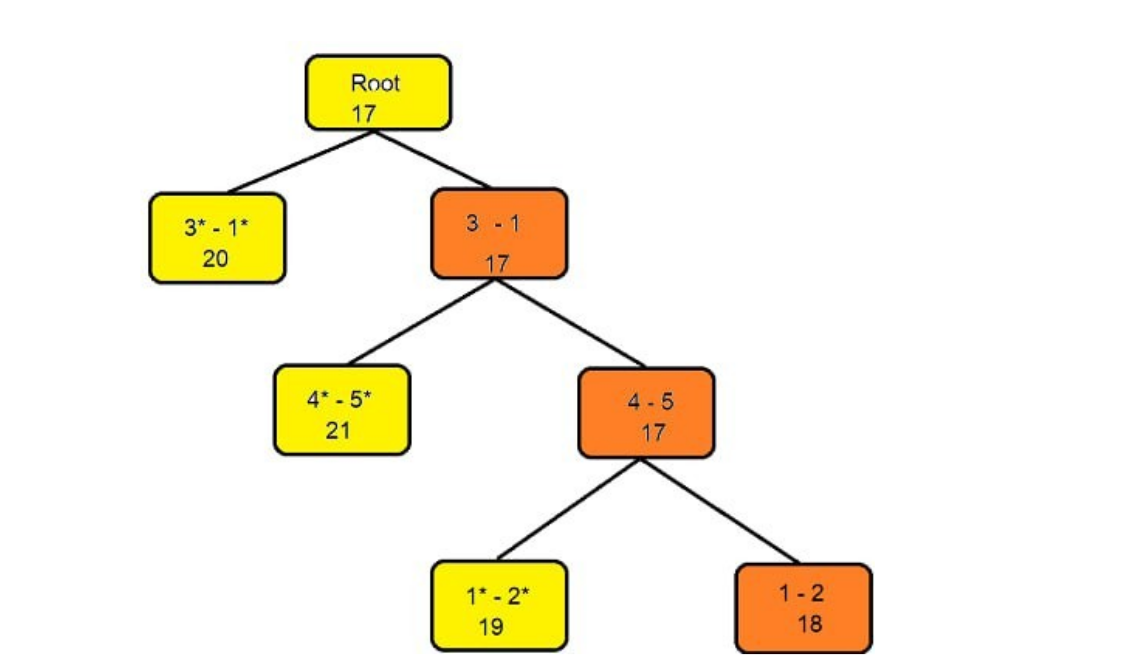

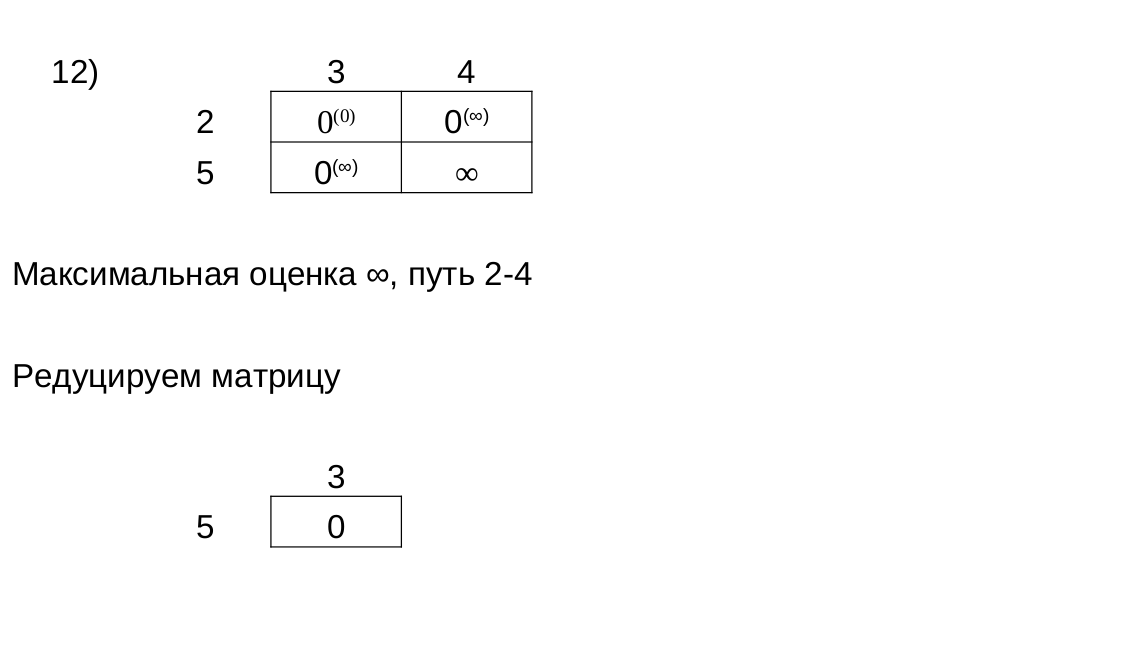

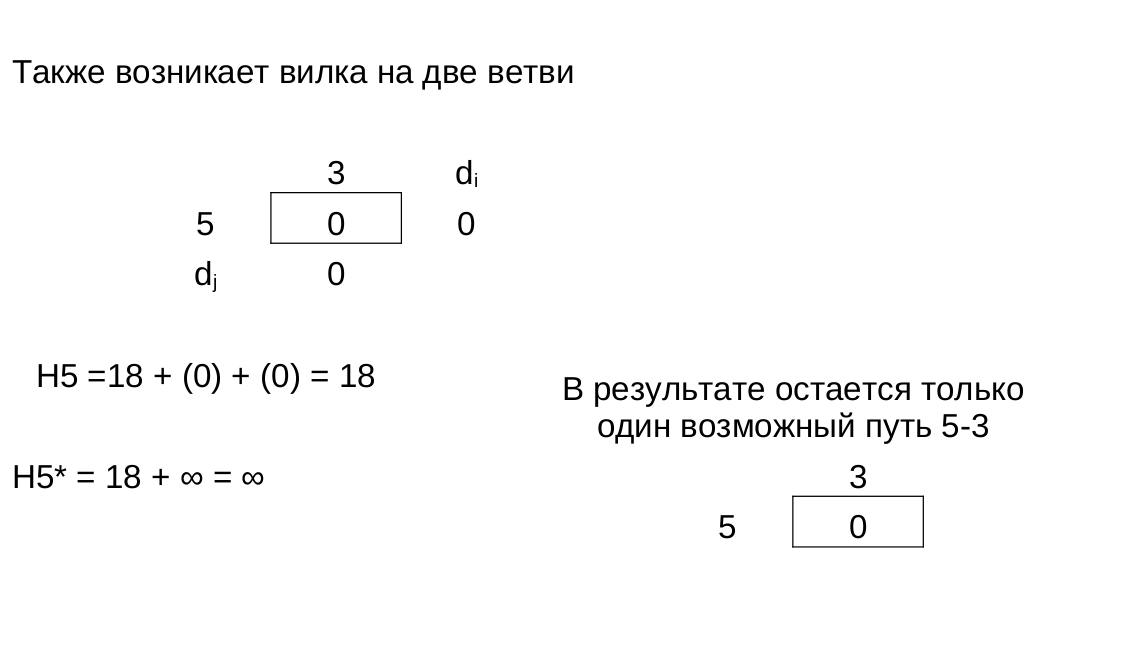

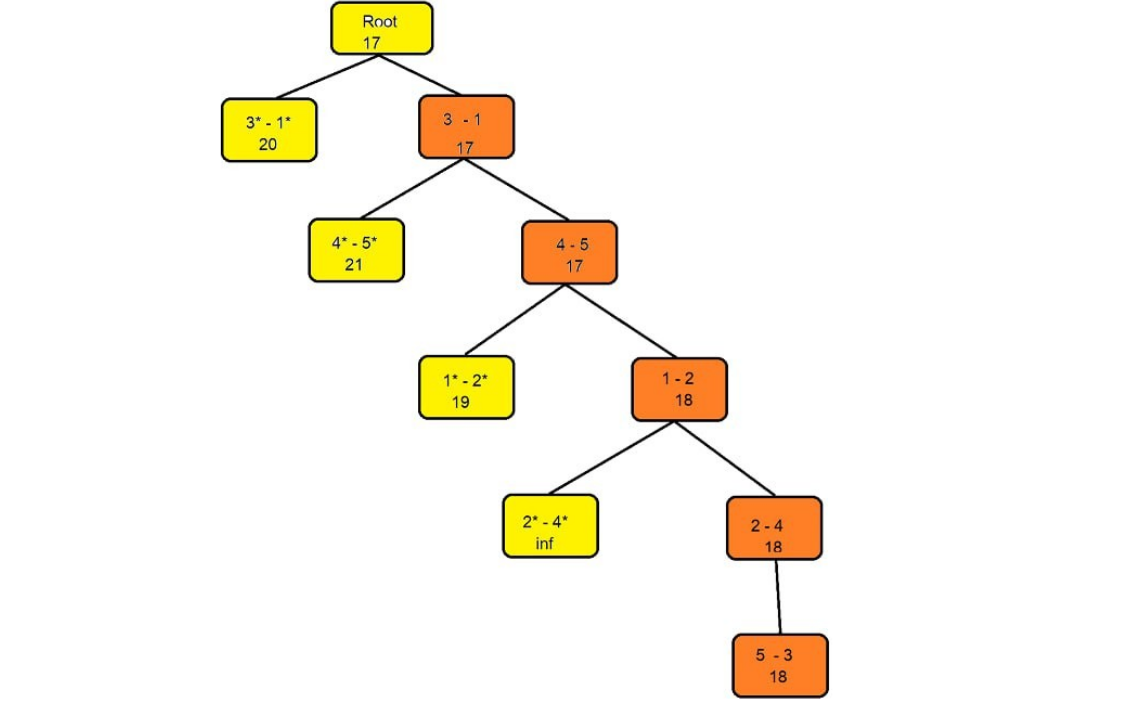

### Итоговый маршрут  3 -> 1 -> 2 -> 4 -> 5 -> 3
### Итоговая стоимость: 18

## Проверка с помощью ORTools

In [2]:
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

In [58]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
        [0, 4, 5, 7, 5],
        [8, 0, 5, 6, 6],
        [3, 5, 0, 9, 6],
        [3, 5, 6, 0, 2 ],
        [6, 2, 3, 8, 0],

        # fmt: on
    ]
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data



def print_solution(data,manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distanse = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}: \n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)+1} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)

        plan_output += f" {manager.IndexToNode(index)+1}\n"
        print(plan_output)
        plan_output += f"Route distance: {route_distance}m\n"
        max_route_distanse = max(max_route_distanse, route_distance)
    print(f"Maximum of the route distances: {max_route_distanse}m")


def main():
    
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    

    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,
        3000,
        True,
        dimension_name
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        print_solution(data, manager, routing, solution)

In [59]:
if __name__ == "__main__":
    main()


Objective: 1818
Route for vehicle 0: 
 1 -> 2 -> 4 -> 5 -> 3 -> 1

Maximum of the route distances: 18m


Видим, что результат по длине и порядка маршрута совпадает с аналитическим

## Проверка с помощью метода отжига

In [62]:
import math
import time
import random
from copy import deepcopy


def compute_way_cost(matrix, path):
    total_cost = 0
    for i in range(0, len(path)-1):
        first_city = path[i]
        second_city = path[i+1]
        if matrix[first_city][second_city] == '*':
            return False
        total_cost += matrix[first_city][second_city]
    first_city = path[-1]
    second_city = path[0]
    if matrix[first_city][second_city] == "*":
        return False
    total_cost += matrix[first_city][second_city]
    return total_cost


def get_new_way(path):
    new_way = deepcopy(path)
    first = random.randint(0, len(path)-1)
    second = random.randint(0, len(path)-1)
    while second == first:
        second = random.randint(0, len(path)-1)

    new_way[first], new_way[second] = new_way[second], new_way[first]
    return new_way


def simulated_annealing(matrix, t_0=1000.0, t_min=0.005):
    length = len(matrix)
    template = list(range(0, length))

    global start_time
    start_time = time.time()
    global_min_cost = False
    while not global_min_cost:
        random.shuffle(template)
        global_min_cost = compute_way_cost(matrix, template)
        global_min_way = template
    t_k = t_0
    k = 1
    current_way = template
    current_way_cost = compute_way_cost(matrix, template)
    
    # print(current_way)
    
    while t_k > t_min:
        # t_k = t_0 / math.log(1+k)
        t_k = t_0 / (1+k)
        k += 1
        
        cost = False
        while not cost:
            new_way = get_new_way(current_way)
            cost = compute_way_cost(matrix, new_way)
        dcost = cost - current_way_cost
        if dcost <= 0:
            current_way_cost = cost
            current_way = new_way
        else:
            change_prob = math.exp(-dcost/t_k)
            random_point = random.random()
            if random_point > change_prob:
                continue
            else:
                current_way_cost = cost
                current_way = new_way

        if current_way_cost < global_min_cost and current_way_cost != False:
            global_min_cost = current_way_cost
            global_min_way = current_way

    return global_min_way, global_min_cost, k, matrix



In [75]:
matr = [
    ['*', 4.0, 5.0, 7.0, 5.0],
    [9.0, '*', 5.0, 6.0, 6.0],
    [3, 5.0, '*', 9.0, 6.0],
    [3.0, 5.0, 6.0, '*', 2.0],
    [6.0, 2.0, 3.0, 8.0, '*']
]


a, b, c, m = simulated_annealing(matr, t_0=1000, t_min=0.001)
seconds = time.time() - start_time
a = ' -> '.join([str(i+1) for i in a])+f' -> {str(a[0]+1)}'
print("Алгоритм: Имитация отжига")
print(f"Количество итераций: {c}")
print(f"Время выполнения: {seconds} секунд")
print(f"Маршрут обхода: {a}")
print(f"Стоимость: {round(b, 1)}")

Алгоритм: Имитация отжига
Количество итераций: 1000000
Время выполнения: 4.7448155879974365 секунд
Маршрут обхода: 3 -> 1 -> 2 -> 4 -> 5 -> 3
Стоимость: 18.0


Результаты также совпали с аналитическим решением, следовательно решение верно

При увелечении начальной температуры увеличивается количество итераций и время выполнения метода

Так же стоимость обхода зависит от начальной температы, чем ближе она к минимальной, тем больше вероятность ошибочного предсказания